In [1]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Sequence, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch,lightning,scikit-learn --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy       : 1.26.4
pandas      : 2.2.1
matplotlib  : 3.8.3
torch       : 2.2.2
lightning   : 2.2.1
scikit-learn: 1.4.1.post1

conda environment: torch_p11



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

## Load Data

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


fp: str = "../../data/mnist"
train_dataset = datasets.MNIST(
    root=fp, train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(root=fp, train=False, transform=transforms.ToTensor())

In [5]:
len(train_dataset), len(test_dataset)

(60000, 10000)

### Create Validation Set

In [6]:
import torch
from torch.utils.data.dataset import random_split


# Split the data
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    train_dataset, lengths=[55000, 5000], generator=generator
)

In [7]:
# Create dataloaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

### Check Label Distribution

In [8]:
from collections import Counter


train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

console.print("\nTraining label distribution:")
console.print(sorted(train_counter.items()))


val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())

console.print("\nValidation label distribution:")
console.print(sorted(val_counter.items()))


test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

console.print("\nTest label distribution:")
console.print(sorted(test_counter.items()))

Training label distribution:

[(0, 5441), (1, 6190), (2, 5477), (3, 5600), (4, 5346), (5, 5000), (6, 5422), (7, 5710), (8, 5347), (9, 5467)]

Validation label distribution:

[(0, 482), (1, 552), (2, 481), (3, 531), (4, 496), (5, 421), (6, 496), (7, 555), (8, 504), (9, 482)]

Test label distribution:

[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]

### Zero-rule baseline (majority class classifier)

In [9]:
majority_class: tuple[int, int] = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc: float = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 1
Accuracy when always predicting the majority class:
0.11 (11.35%)


### Visual Check

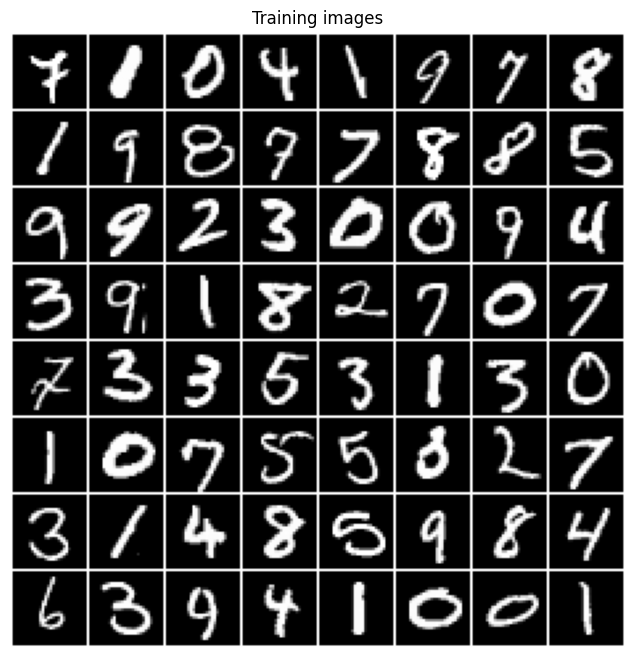

In [10]:
import torchvision


for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            images[:64], padding=1, pad_value=1.0, normalize=True
        ),
        (1, 2, 0),
    )
)
plt.show()

In [11]:
images.shape  # batchsize, channel, height, width

torch.Size([64, 1, 28, 28])

In [12]:
torch.flatten(images, start_dim=1).shape  # batchsize, features

torch.Size([64, 784])

In [13]:
# OR
images.view(64, -1).shape

torch.Size([64, 784])

### Combination of Sequential And Class API

```py
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits
```

In [14]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features: int, num_classes: int) -> None:
        """Multi-layer perceptron (MLP) with two hidden layers."""
        super().__init__()

        # 1st hidden layer
        self.fc1 = nn.Linear(num_features, 50)
        self.relu1 = nn.ReLU()
        # 2nd hidden layer
        self.fc2 = nn.Linear(50, 25)
        self.relu2 = nn.ReLU()
        # Ouput layer
        self.fc3 = nn.Linear(25, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Convert input to 2D tensor
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        logits: torch.Tensor = self.fc3(x)
        return logits


# I like this syntax more because it requires less code
class PyTorchMLP(nn.Module):
    def __init__(self, num_features: int, num_classes: int) -> None:
        """Multi-layer perceptron (MLP) with two hidden layers."""
        super().__init__()

        self.all_layers = nn.Sequential(
            # 1st hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            # 2nd hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            # Output layer
            nn.Linear(25, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.flatten(x, start_dim=1)
        logits: torch.Tensor = self.all_layers(x)
        return logits

## Training Loop

In [15]:
Model: TypeAlias = nn.Module


def compute_accuracy(model: Model, dataloader: DataLoader) -> float:

    model = model.eval()

    correct: float = 0.0
    total_examples: int = 0

    for _, (features, labels) in enumerate(dataloader):

        with torch.inference_mode():  # Same as torch.no_grad
            logits = model(features)

        predictions: torch.Tensor = torch.argmax(logits, dim=1)

        compare: bool = (labels == predictions).float()
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [16]:
torch.manual_seed(1)
model: Model = PyTorchMLP(num_features=784, num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

epochs: int = 10

loss_list: list[float] = []
train_acc_list, val_acc_list = [], []

for epoch in tqdm(range(epochs)):
    # Training mode
    model = model.train()

    for batch_idx, (features, labels) in enumerate(train_loader):

        # Forward propagation
        optimizer.zero_grad()
        logits = model(features)

        # Compute loss
        loss = F.cross_entropy(logits, labels)

        # Back propagation
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{epochs:03d}"
                f" | Batch {batch_idx+1:03d}/{len(train_loader):03d}"
                f" | Train/Val Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    # Compute accuracy
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    console.print(
        f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%", style="info"
    )
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 001/010 | Batch 001/860 | Train/Val Loss: 2.30
Epoch: 001/010 | Batch 251/860 | Train/Val Loss: 0.27
Epoch: 001/010 | Batch 501/860 | Train/Val Loss: 0.50
Epoch: 001/010 | Batch 751/860 | Train/Val Loss: 0.33


Train Acc: 89.90% | Val Acc: 89.10%

Epoch: 002/010 | Batch 001/860 | Train/Val Loss: 0.65
Epoch: 002/010 | Batch 251/860 | Train/Val Loss: 0.23
Epoch: 002/010 | Batch 501/860 | Train/Val Loss: 0.49
Epoch: 002/010 | Batch 751/860 | Train/Val Loss: 0.72


Train Acc: 89.34% | Val Acc: 88.38%

Epoch: 003/010 | Batch 001/860 | Train/Val Loss: 0.33
Epoch: 003/010 | Batch 251/860 | Train/Val Loss: 0.63
Epoch: 003/010 | Batch 501/860 | Train/Val Loss: 0.40
Epoch: 003/010 | Batch 751/860 | Train/Val Loss: 0.39


Train Acc: 88.73% | Val Acc: 87.80%

Epoch: 004/010 | Batch 001/860 | Train/Val Loss: 0.48
Epoch: 004/010 | Batch 251/860 | Train/Val Loss: 0.28
Epoch: 004/010 | Batch 501/860 | Train/Val Loss: 0.47
Epoch: 004/010 | Batch 751/860 | Train/Val Loss: 0.51


Train Acc: 89.50% | Val Acc: 88.24%

Epoch: 005/010 | Batch 001/860 | Train/Val Loss: 0.37
Epoch: 005/010 | Batch 251/860 | Train/Val Loss: 0.30
Epoch: 005/010 | Batch 501/860 | Train/Val Loss: 0.28
Epoch: 005/010 | Batch 751/860 | Train/Val Loss: 0.36


Train Acc: 90.49% | Val Acc: 89.24%

Epoch: 006/010 | Batch 001/860 | Train/Val Loss: 0.23
Epoch: 006/010 | Batch 251/860 | Train/Val Loss: 0.31
Epoch: 006/010 | Batch 501/860 | Train/Val Loss: 0.60
Epoch: 006/010 | Batch 751/860 | Train/Val Loss: 0.47


Train Acc: 89.56% | Val Acc: 88.22%

Epoch: 007/010 | Batch 001/860 | Train/Val Loss: 0.43
Epoch: 007/010 | Batch 251/860 | Train/Val Loss: 0.34
Epoch: 007/010 | Batch 501/860 | Train/Val Loss: 0.27
Epoch: 007/010 | Batch 751/860 | Train/Val Loss: 0.25


Train Acc: 88.98% | Val Acc: 88.42%

Epoch: 008/010 | Batch 001/860 | Train/Val Loss: 0.53
Epoch: 008/010 | Batch 251/860 | Train/Val Loss: 0.25
Epoch: 008/010 | Batch 501/860 | Train/Val Loss: 0.23
Epoch: 008/010 | Batch 751/860 | Train/Val Loss: 0.74


Train Acc: 89.10% | Val Acc: 87.38%

Epoch: 009/010 | Batch 001/860 | Train/Val Loss: 0.29
Epoch: 009/010 | Batch 251/860 | Train/Val Loss: 0.46
Epoch: 009/010 | Batch 501/860 | Train/Val Loss: 0.14
Epoch: 009/010 | Batch 751/860 | Train/Val Loss: 0.43


Train Acc: 89.65% | Val Acc: 88.72%

Epoch: 010/010 | Batch 001/860 | Train/Val Loss: 0.38
Epoch: 010/010 | Batch 251/860 | Train/Val Loss: 0.40
Epoch: 010/010 | Batch 501/860 | Train/Val Loss: 0.43
Epoch: 010/010 | Batch 751/860 | Train/Val Loss: 0.18


Train Acc: 87.93% | Val Acc: 87.04%

### Evaluation

In [17]:
train_acc: float = compute_accuracy(model, train_loader)
val_acc: float = compute_accuracy(model, val_loader)
test_acc: float = compute_accuracy(model, test_loader)

console.print(f"Train Acc: {train_acc*100:.2f}%")
console.print(f"Val Acc: {val_acc*100:.2f}%")
console.print(f"Test Acc: {test_acc*100:.2f}%")

Train Acc: 87.93%

Val Acc: 87.04%

Test Acc: 87.55%

In [18]:
def go_up_from_current_directory(go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Args:
    -----
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [19]:
go_up_from_current_directory(go_up=2)

from src.helper_plotting import plot_training_loss, plot_accuracy, show_examples

/Users/neidu/Desktop/Projects/Personal/My_Projects/Deep-Learning-With-Pytorch


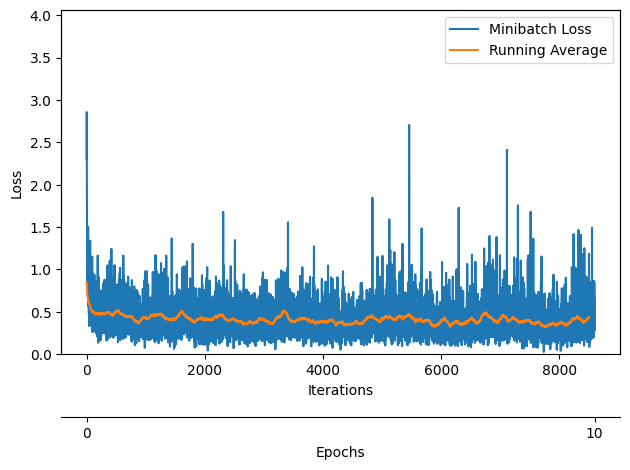

In [20]:
plot_training_loss(
    minibatch_loss_list=loss_list,
    num_epochs=epochs,
    iter_per_epoch=len(loss_list) // epochs,
)

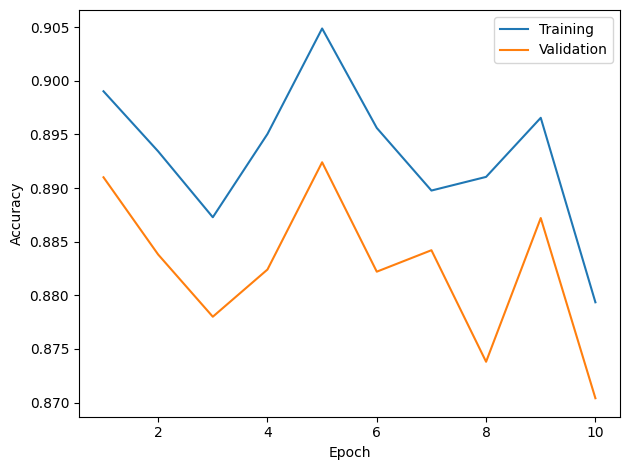

In [21]:
plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=val_acc_list)

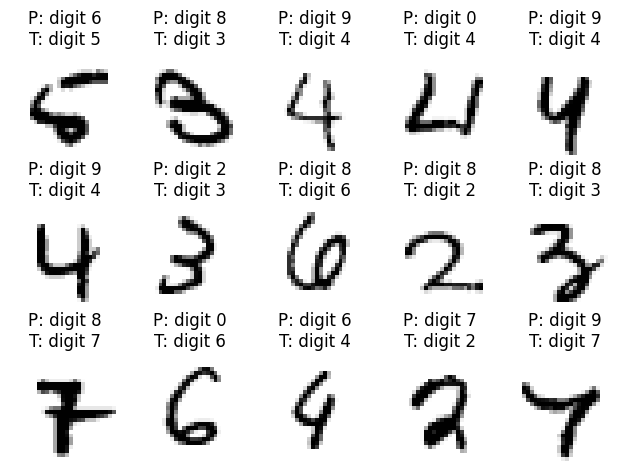

In [22]:
class_dict = {
    0: "digit 0",
    1: "digit 1",
    2: "digit 2",
    3: "digit 3",
    4: "digit 4",
    5: "digit 5",
    6: "digit 6",
    7: "digit 7",
    8: "digit 8",
    9: "digit 9",
}

show_examples(model=model, data_loader=test_loader, class_dict=class_dict)

In [ ]:
# NEW !!!


class MNISTDataModule(L.LightningDataModule):
    def __init__(self, data_dir="./mnist", batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def prepare_data(self):
        # download
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        self.mnist_test = datasets.MNIST(
            self.data_dir, transform=transforms.ToTensor(), train=False
        )
        self.mnist_predict = datasets.MNIST(
            self.data_dir, transform=transforms.ToTensor(), train=False
        )
        mnist_full = datasets.MNIST(
            self.data_dir, transform=transforms.ToTensor(), train=True
        )
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000], generator=torch.Generator().manual_seed(42))

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)



# Unit 5.5. Organizing Your Data Loaders with Data Modules

import lightning as L
import torch
from shared_utilities import LightningModel, MNISTDataModule, PyTorchMLP
from watermark import watermark

if __name__ == "__main__":

    print(watermark(packages="torch,lightning", python=True))
    print("Torch CUDA available?", torch.cuda.is_available())

    torch.manual_seed(123)

    # NEW !!!
    dm = MNISTDataModule()

    pytorch_model = PyTorchMLP(num_features=784, num_classes=10)

    lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

    trainer = L.Trainer(
        max_epochs=10, accelerator="cpu", devices="auto", deterministic=True
    )

    # NEW !!!
    # trainer.fit(model=lightning_model,
    #             train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.fit(model=lightning_model, datamodule=dm)

    train_acc = trainer.validate(dataloaders=dm.train_dataloader())[0]["val_acc"]
    val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
    test_acc = trainer.test(datamodule=dm)[0]["test_acc"]
    print(
        f"Train Acc {train_acc*100:.2f}%"
        f" | Val Acc {val_acc*100:.2f}%"
        f" | Test Acc {test_acc*100:.2f}%"
    )


PATH = "lightning.pt"
torch.save(pytorch_model.state_dict(), PATH)

# To load model:
# model = PyTorchMLP(num_features=784, num_classes=10)
# model.load_state_dict(torch.load(PATH))
# model.eval()
